In [8]:
# %matplotlib widget
import sys, os, importlib
package_path = os.path.abspath('..')    
if package_path not in sys.path:
    sys.path.append(package_path)
from package import functions as fn
from package import model as rm
from package import optimizer as opt
from package import plots
import numpy as np
from obspy.taup import TauPyModel
np.set_printoptions(precision=4, suppress=True)

Original params:  [315.  90. 180.]


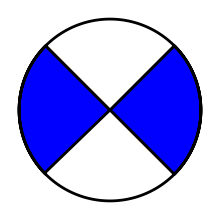

In [9]:
np.random.seed(2025)

# generate synthetic data
t, p = fn.i_hat, fn.j_hat

# get true params for synthetic test
true_params = fn.tp2sdr(t, p, True)[0]
print('Original params: ', true_params)

# plot corresponding beachball
beachball = fn.beachball(true_params)

# set up parameters for inversion
model = TauPyModel(model='ak135')  # velocity model
hdepth = 15  # km - assumed quake depth
epdist = 10  # degrees - epicentral distance
azimuth = 200  # degrees - azimuth of seismometer
p_arrivals = model.get_travel_times(source_depth_in_km=hdepth,
                        distance_in_degree=epdist, phase_list=['P'])
s_arrivals = model.get_travel_times(source_depth_in_km=hdepth,
                        distance_in_degree=epdist, phase_list=['S'])
takeoff_angles = [p_arrivals[0].takeoff_angle, s_arrivals[0].takeoff_angle]
velocities = np.array([5.8000, 3.4600])

In [10]:
importlib.reload(rm)

# initialize model
radiation_model = rm.RadiationModel(np.deg2rad(azimuth), takeoff_angles, velocities)

model_Ao = radiation_model(np.deg2rad(true_params), set_Ao=True, return_A=True)

# tune hyperparameters
config = opt.get_config()

# multistart optimization
num_starts = 50
starts = fn.random_params(num_starts)

radiation_model.reset()
print_every = 10

for index, start in enumerate(starts):
    if print_every > 0 and index % print_every == 0:
        print(f'Run {index} of {num_starts}')
    opt.minimize(radiation_model, config, start)
    
print(f'Convergence rate: {radiation_model.get_convergence_rate():.0f}%')

Using sdr parameters.
Run 0 of 50
Run 10 of 50
Run 20 of 50
Run 30 of 50
Run 40 of 50
Convergence rate: 96%


In [11]:
params, error, position = radiation_model.get_optimal_parameters(z_threshold=2)
name = 'T' if position == 0 else 'P'

print(f'Constrained axis: {name}')
print(f'Optimal parameters: {np.rad2deg(params)}')
print(f'Search error: {np.rad2deg(error)} degrees')

Constrained axis: P
Optimal parameters: [101.6889  79.0297  14.7906]
Search error: 0.8282251363107972 degrees


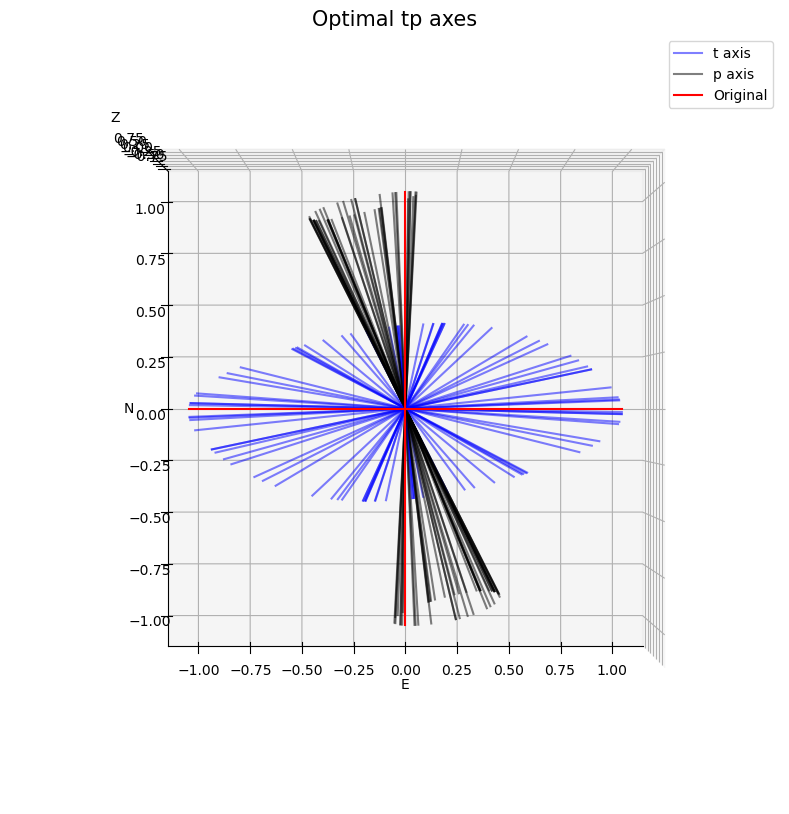

In [16]:
importlib.reload(plots)

plots.tp_axes(radiation_model, azim=-90, elev=90, half=False)

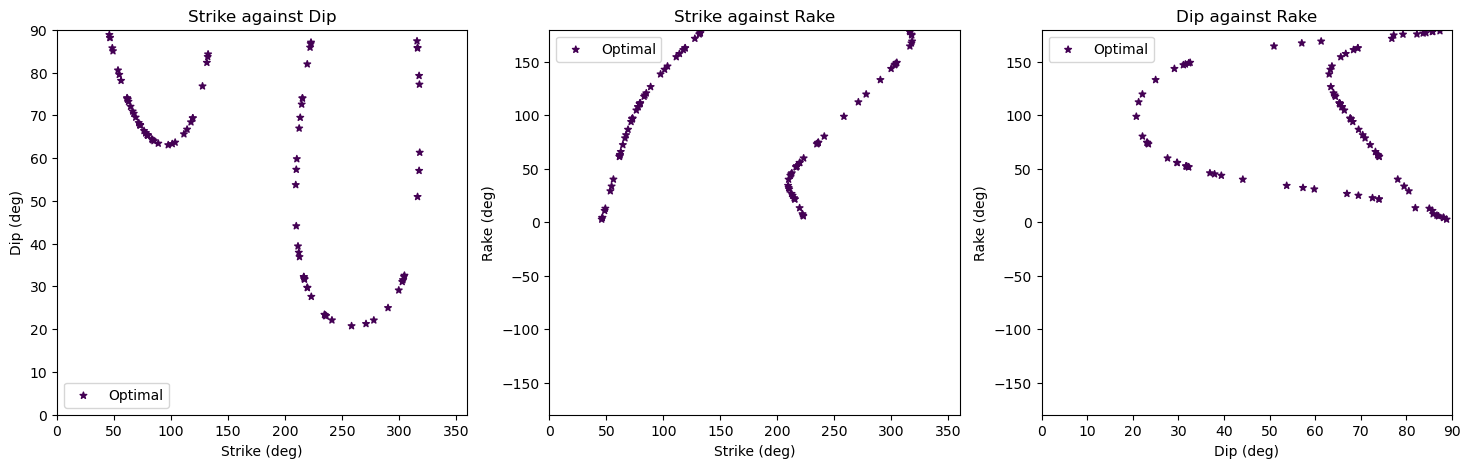

In [17]:
plots.iterates_2D(radiation_model, s=25, optimal=True, index=2, cmap='viridis')